In [1]:
# Librerias

import pandas as pd
import numpy as np
import os
import cv2
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples

In [2]:
# Cargar la imagen
target = 'Ermine.jpg' #img2.jpg'#'palette.png'#
img_original = cv2.cvtColor(cv2.imread(target), cv2.COLOR_BGR2RGB)

 las dimensiones de la variable que se le entrega al algoritmo son: (66000, 3)


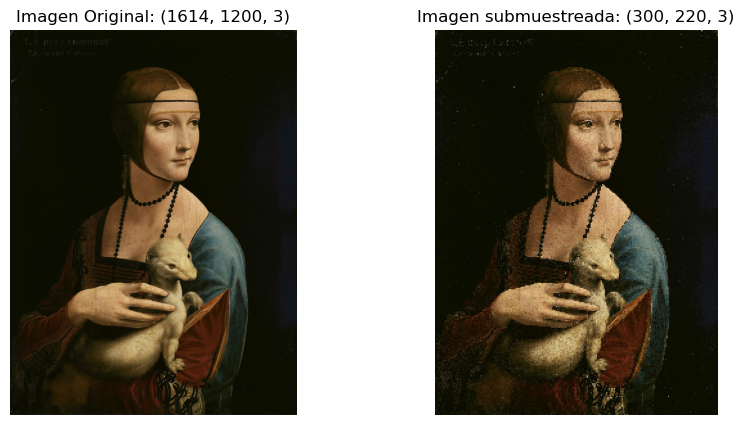

In [3]:
# Pre-procesamiento de la imagen:  

# submuestreo para ahorrar recursos computacionales
nuevo_ancho = 220
nuevo_alto = 300
nuevo_tamanio = (nuevo_ancho, nuevo_alto)

# Cambiar el tamaño de la imagen
img_submuestreada = cv2.resize(img_original, nuevo_tamanio)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f'Imagen Original: {img_original.shape}')
plt.imshow(img_original)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title(f'Imagen submuestreada: {img_submuestreada.shape}')
plt.imshow(img_submuestreada)
plt.axis('off')

# Transformar a YcBCr
#img_ycbcr = cv2.cvtColor(img_submuestreada, cv2.COLOR_RGB2YCrCb) #(Convertirla a YCrCb puede ser util?)

# Darle formato a la imagen
img_final = img_submuestreada.reshape((-1, 3))/255 # No hay que escalar por que se está haciendo aqui teniendo en cuenta el rango definido de RGB
(total_pixels,n) = img_final.shape
print(f' las dimensiones de la variable que se le entrega al algoritmo son: {total_pixels,n}')

In [4]:
# DBSCAN para hallar los grupos

def silhouette_scores_DBSCAN(X, eps_list, min_samples_list, metric = 'euclidean'):
    """
    Calcula el coeficiente de la silueta para todas las combinaciones de (eps, min_samples) usando DBSCAN
    
    Parametros:
    X : np.array
        El arreglo con los datos
    eps_list : list
        Lista de valores para el hiperparámetro épsilon
    min_samples_list : list
        Lista de valores para el hiperparámetro min_samples
    metric : str
        Métrica de distancia a utilizar
    """
    # Vamos a almacenar cada combinación, el coeficiente de la silueta y el número de clústeres
    scores, eps_scores, min_samples_scores, num_clusters = [], [], [], []
    # Definimos la búsqueda exhaustiva con dos ciclos
    # El primero recorre todos los valores de épsilon
    for i in range(len(eps_list)):
        # Y el segundo recorre todos los valores de min_samples
        for j in range(len(min_samples_list)):
            # Obtenemos los valores actuales para los hiperparámetros
            eps_i = eps_list[i]
            min_samples_j = min_samples_list[j]
            eps_scores.append(eps_i)
            min_samples_scores.append(min_samples_j)
            # Definimos un modelo de DBSCAN con los valores actuales
            model_ij = DBSCAN(eps=eps_i, min_samples=min_samples_j, metric=metric, n_jobs=-1)
            # Entrenamos el modelo
            model_ij.fit(X)
            labels_ij = model_ij.labels_
            num_clusters_ij = len(set(labels_ij))
            num_clusters.append(num_clusters_ij)
            # Almacenamos el coeficiente de la silueta
            # Si tenemos un número de clústeres mayor a 1, el coeficiente de la silueta está definido
            if num_clusters_ij > 1:
                score = silhouette_score(X, labels_ij)
                scores.append(score)
            # Si DBSCAN retorna un solo clúster, el coeficiente de la silueta no está definido
            else:
                scores.append(-1)
    # Construimos un DataFrame para retornar el resultado
    scores_df = pd.DataFrame({
        'epsilon': eps_scores,
        'min_samples': min_samples_scores,
        'score': scores,
        'num_clusters': num_clusters
    })
    # Retornamos el DataFrame ordenado por el coeficiente promedio
    return scores_df.sort_values('score', ascending=False)

In [5]:
# Valores de Épsilon
eps_list = np.linspace(0.0025,0.015,5)#[0.0075,0.03,0.035,0.045]
# Valores del mínimo de puntos
min_samples_list = [1200]#[int(total_pixels/250), int(total_pixels/100)]#[25,500,1000,2500]

silhouette_scores = silhouette_scores_DBSCAN(img_final, eps_list, min_samples_list)
silhouette_scores[0:5]


KeyboardInterrupt



In [ ]:
#mejor_DBSCAN = silhouette_scores[(silhouette_scores['num_clusters'] >= 5) & (silhouette_scores['num_clusters'] <= 7)].iloc[0]
mejor_DBSCAN = silhouette_scores.iloc[0]

In [ ]:
eps_ = mejor_DBSCAN['epsilon']
min_s = int(mejor_DBSCAN['min_samples'])

In [ ]:
# Etapa 2: Método de clustering Fuzzy C-Means o K-Means
agrupador = DBSCAN(eps=eps_, min_samples=min_s, metric='euclidean', n_jobs=-1)
agrupador.fit(img_final)

# Extraer las etiquetas de los clústeres
labels = agrupador.labels_
# Calcular los centróides de los clústeres
colors = []
# Recorre cada clúster identificado (ignora el ruido, que tiene la etiqueta -1)
for cluster_id in np.unique(labels):
    if cluster_id != -1:
        # Seleccionar los puntos del clúster actual
        cluster_points = img_final[labels == cluster_id]
        
        # Calcular el centróide como el promedio de los puntos
        centroid = cluster_points.mean(axis=0)
        colors.append(centroid)
colors = np.array(colors)

In [ ]:
# Mostrar la imagen original junto con su paleta de colores
fig, ax = plt.subplots(1,2,figsize=(5, 3))  

ax[0].imshow(img_original)
ax[0].set_title('Imagen Original')
ax[0].axis('off')
# crear la paleta
for i, color in enumerate(colors):
    ax[1].bar(i, height=1, color=color, edgecolor='none', width=1)

ax[1].set_title('Paleta de Colores')
ax[1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Assuming `X` is your input data
k = 6  # Typically use `minPts` value
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(img_final)
distances, indices = nbrs.kneighbors(img_final)

# Sort the distances (4th column here) and plot
distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.title(f'k-distance graph for k={k}')
plt.show()


In [ ]:
# Mostrar el resultado